In [ ]:
# %cd ..
# import os
# print(os.getcwd())

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb

import sys
sys.path.append(os.path.abspath('..'))
from utils.items import Item
from utils.testing import Tester

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_dotenv()
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

True

## Inference with RAG without using Langchain

Preparing the call to the model

In [3]:
openai = OpenAI()

In [16]:
# Loading the previously saved model
with open('../Data/validation.pkl', 'rb') as file:
    validation = pickle.load(file)
    print(len(validation))

4000


In [19]:
validation[:3]

[<Arlo Q 1080p Hd Security Camera With Audio 2 Pack = $149.99>,
 <Baja Designs 55-51005 Squadron Sport Flush Mount LED Wide Cornering,1 Pack = $141.95>,
 <R&M Specialties 1120S Satin Spark Plug Wire Loom Set with Center-Bolt Valve Cover for Small Block Chevy = $80.6>]

In [20]:
def make_context(similars, prices):
    message = "Study the prices of these other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [21]:
# Defining the state to call the LLM
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

Calling the previously stored collection

In [23]:
DB = "DB_products_vectorstore"
collection_name = "Amazon_reviews_products"

In [26]:
client = chromadb.PersistentClient(path="../Data/chromaDB")
collection = client.get_or_create_collection(collection_name)

Preparing the query

In [9]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [10]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [11]:
def vector(item):
    return model.encode([description(item)])

In [34]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [35]:
documents, prices = find_similars(validation[0])
print(make_context(documents, prices))

Study the prices of these other items that might be similar to the item you need to estimate.

Potentially related product:
Arlo Pro 3 – Wire-Free Security 2 Camera System | 2K with HDR, Indoor/Outdoor, Color Night Vision, Spotlight, 160° View, 2-Way Audio, Siren | Works with Alexa | (Renewed)
ARLO Arlo Pro 3 Wire-Free Sec 2 Cam Sys White Wire-free and weather-resistant design, works with Alexa and Google Assistant, and includes Arlo Secure Trial with cloud recording 2K video with HDR zoom in on objects and see clearer details and colors in 2K HDR Color night vision see what’s lurking with color night vision or black and white. Battery Life - 3-6 months. Charge Time to Full (via camera)- 3.5 hrs. Charge time to
Price is $242.99

Potentially related product:
Arlo Pro Wire-Free HD Camera Security System Kit)
Your World, Just a Tap Away Whether you're using a smartphone, tablet or computer, you can check in to Arlo with only a few clicks. The free Arlo app is available for iOS, Android, A

In [36]:
# print(messages_for(validation[0], documents, prices))

In [37]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

# Calling the Model

In [38]:
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [39]:
print("GPT estimate: ", gpt_4o_mini_rag(validation[0]))
print("Real value: ",validation[0].price)

GPT estimate:  129.99
Real value:  149.99


## Making Inference with RAG using GPT-4o-mini

Remember the number validation data is 4000 datapoints. I will initially test over just 250. The Tester class has a size variable set to 250.

1: Guess: $129.99 Truth: $149.99 Error: $20.00 SLE: 0.02 Item: Arlo Q 1080p Hd Security Camera With Aud...
2: Guess: $141.95 Truth: $141.95 Error: $0.00 SLE: 0.00 Item: Baja Designs 55-51005 Squadron Sport Flu...
3: Guess: $149.99 Truth: $80.60 Error: $69.39 SLE: 0.38 Item: R&M Specialties 1120S Satin Spark Plug W...
4: Guess: $29.99 Truth: $94.99 Error: $65.00 SLE: 1.28 Item: Logitech Deluxe Access Keyboard
5: Guess: $319.00 Truth: $199.00 Error: $120.00 SLE: 0.22 Item: Shure PGXD4=-X8 Digital Wireless Receive...
6: Guess: $199.99 Truth: $144.14 Error: $55.85 SLE: 0.11 Item: Barnett Performance Products Complete Di...
7: Guess: $136.99 Truth: $187.50 Error: $50.51 SLE: 0.10 Item: Dell Optiplex 9020 Business Tower Comput...
8: Guess: $120.00 Truth: $138.00 Error: $18.00 SLE: 0.02 Item: Fujifilm Finepix S6000fd 6.3MP Digital C...
9: Guess: $168.82 Truth: $163.47 Error: $5.35 SLE: 0.00 Item: URO Parts 1078202866 Tail Light Lens, Ri...
10: Guess: $19.99 Truth: $2.85 Error: $17.14 SLE: 2.8

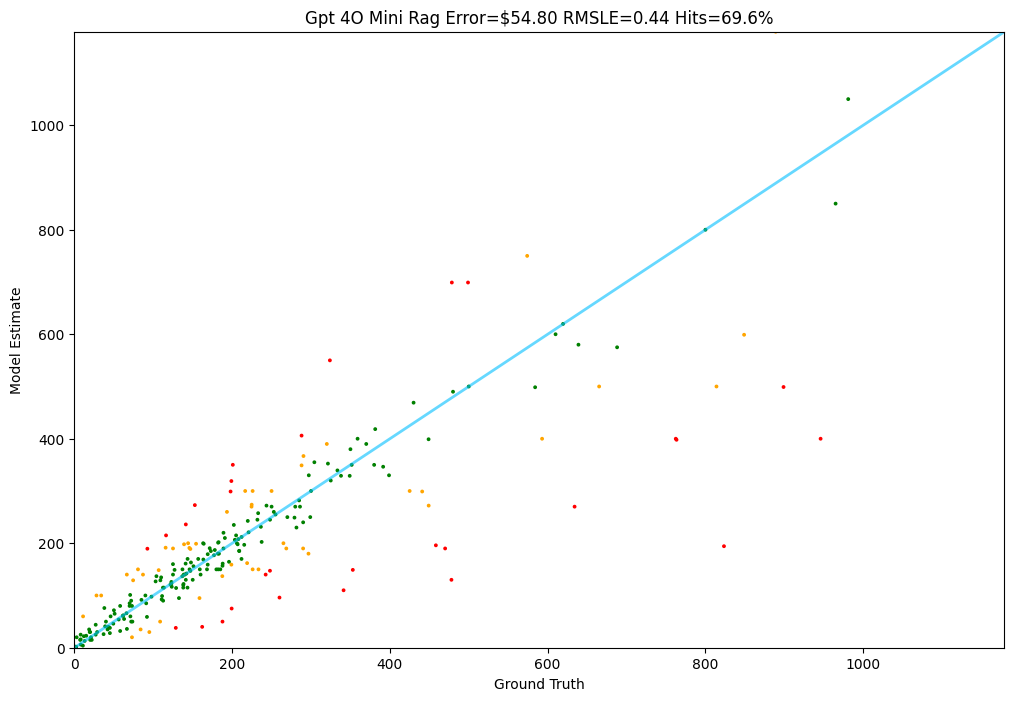

In [ ]:
Tester.test(gpt_4o_mini_rag, validation)